In [65]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
import ipdb
import re
from datasets import load_dataset
import os
from diversity import compression_ratio, ngram_diversity_score, extract_patterns, get_pos, pos_patterns, token_patterns, self_repetition_score
import json
from collections import Counter
from random import shuffle

tqdm.pandas()

import matplotlib.pyplot as plt
# import mplcursors
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid', context='notebook', rc={'figure.figsize':(14,10), 'font.family': 'Times'}, font_scale=2)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('chained_assignment',None)

# Set random seeds for reproducibility on a specific machine
random.seed(1)
np.random.seed(1)
np.random.RandomState(1)
np.set_printoptions(precision=3)

In [2]:
def calc_cr_nds_sr(responses):
    cr = compression_ratio(responses, 'gzip')
    nds = ngram_diversity_score(responses, 4)
    #CR-POS
    joined_pos, tuples = get_pos(responses)
    # ngrams_pos = token_patterns(joined_pos, 5, 10)
    cr_pos = compression_ratio(joined_pos, 'gzip')
    srep = self_repetition_score(responses, verbose=False)
    return cr, cr_pos, nds, srep

def calc_diversity(df, num_shuffles=10):
    '''
    Randomly assigns personas with prompts, calculates metrics over responses for these
    pairings, then calculates mean and S.D over 10 different random pairings
    '''
    random.seed(1)
    crs = []
    ndss = []
    crs_pos = []
    sreps = []
    new_df = df.set_index(['persona_id', 'prompt_id'])
    for _ in tqdm(range(num_shuffles)):
        # Get random personas paired with every prompt
        persona_ids_shuffled = [i for i in range(100)]
        random.shuffle(persona_ids_shuffled)
        prompt_ids = [i for i in range(100)]
        pairs = list(zip(persona_ids_shuffled, prompt_ids))
        responses = new_df.loc[pairs, 'response'].values.tolist()
        
        # Calculate metrics
        cr, cr_pos, nds, srep = calc_cr_nds_sr(responses)
    
        crs.append(cr)
        ndss.append(nds)
        crs_pos.append(cr_pos)
        sreps.append(srep)
    
    print(f"CR: {np.round(np.mean(crs),2)} ± {np.round(np.std(crs),2)}\nCR-POS: {np.round(np.mean(crs_pos),2)} ± {np.round(np.std(crs_pos),2)}\nNDS: {np.round(np.mean(ndss),2)} ± {np.round(np.std(ndss),2)}\nSelf-rep:{np.round(np.mean(sreps),2)} ± {np.round(np.std(sreps),2)}")

## Dolly human responses

In [3]:
with open('../data/sample_personas.txt', 'r') as f:
    personas = [x.strip() for x in f.readlines()]
dolly = load_dataset("databricks/databricks-dolly-15k")["train"].filter(lambda row: row['category']=='creative_writing').to_pandas()
sample = pd.read_csv('../data/dolly_creative_prompts_sample.tsv', sep='\t')
sample['response'] = sample['index'].apply(lambda x: dolly.loc[x, 'response'])
sample['prompt_id'] = [i for i in range(len(sample))]
prompts = sample['instruction'].values.tolist()
human_responses = sample['response'].values.tolist()

In [4]:
cr = compression_ratio(human_responses, 'gzip')
nds = ngram_diversity_score(human_responses, 4)
joined_pos, tuples = get_pos(human_responses)
# ngrams_pos = token_patterns(joined_pos, 5, 10)
cr_pos = compression_ratio(joined_pos, 'gzip')
# rouge = homogenization_score(human_responses, 'rougel', verbose=False)
# bleu = homogenization_score(human_responses, 'bleu', verbose=False)
srep = self_repetition_score(human_responses)
# print(f"CR: {np.round(cr,2)}\nNDS: {np.round(nds,2)}\nCR-POS: {np.round(cr_pos,2)}\nHS-RougeL: {np.round(rouge,2)}\nself-bleu: {np.round(bleu,2)}\nSelf-rep: {np.round(srep, 2)}")
print(f"CR: {np.round(cr,2)}\nNDS: {np.round(nds,2)}\nCR-POS: {np.round(cr_pos,2)}\nSelf-rep: {np.round(srep, 2)}")

Calculating self-repetition score: 100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 78062.61it/s]

CR: 2.51
NDS: 3.03
CR-POS: 4.93
Self-rep: 0.55


## Llama-70B

In [5]:
# No persona, no cutoff
np70_df = pd.read_csv('../output/llama-temp0.7/llama70b-np/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
np70_df['response'] = np70_df.response.apply(lambda x: x.strip())
np70_df = np70_df.drop_duplicates(subset=['prompt_id', 'persona_id'], keep='first')
cr, cr_pos, nds, srep = calc_cr_nds_sr(np70_df['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.76
CR-POS: 5.72
NDS: 2.87
Self-rep: 1.96


In [6]:
# No persona with cutoff
npc70_df = pd.read_csv('../output/llama-temp0.7/llama70b-cutoff-np/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
npc70_df['response'] = npc70_df.response.apply(lambda x: x.strip())
npc70_df = npc70_df.drop_duplicates(subset=['prompt_id', 'persona_id'], keep='first')
cr, cr_pos, nds, srep = calc_cr_nds_sr(npc70_df['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.57
CR-POS: 5.1
NDS: 3.1
Self-rep: 0.44


In [7]:
persona70_df = pd.read_csv('../output/llama-temp0.7/llama70b-persona/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
persona70_df['response'] = persona70_df.response.apply(lambda x: x.strip())
persona70_df = persona70_df.drop_duplicates(subset=['prompt_id', 'persona_id'], keep='first')
calc_diversity(persona70_df, num_shuffles=100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:24<00:00,  5.64s/it]

CR: 2.7 ± 0.02
CR-POS: 5.39 ± 0.03
NDS: 2.83 ± 0.01
Self-rep:2.58 ± 0.11


In [8]:
# Persona plus cutoff
personac70_df = pd.read_csv('../output/llama-temp0.7/llama70b-cutoff-persona/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
personac70_df['response'] = personac70_df.response.apply(lambda x: x.strip())
calc_diversity(personac70_df, num_shuffles=100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:41<00:00,  5.82s/it]

CR: 2.52 ± 0.02
CR-POS: 5.04 ± 0.03
NDS: 3.08 ± 0.02
Self-rep:0.72 ± 0.11


In [10]:
# Coarse personas plus cutoff
persona70_df_coarse = pd.read_csv('../output/coarse/llama-cutoff-persona/Llama-3.3-70B-Instruct-Turbo_dolly_output.tsv', sep='\t')
persona70_df_coarse['response'] = persona70_df_coarse.response.apply(lambda x: x.strip())
persona70_df_coarse = persona70_df_coarse.drop_duplicates(subset=['prompt_id', 'persona_id'], keep='first')
calc_diversity(persona70_df_coarse, num_shuffles=100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:33<00:00,  5.74s/it]

CR: 2.51 ± 0.02
CR-POS: 5.06 ± 0.04
NDS: 3.09 ± 0.02
Self-rep:0.61 ± 0.08


## Deepseek

In [7]:
# No persona, no cutoff
deep_npnc = pd.read_csv('../output/deepseek-np/DeepSeek-V3_dolly_output.tsv', sep='\t')
deep_npnc['response'] = deep_npnc.response.apply(lambda x: x.strip())
cr, cr_pos, nds, srep = calc_cr_nds_sr(deep_npnc['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.36
CR-POS: 5.5
NDS: 3.15
Self-rep: 0.86


In [17]:
# No persona, cutoff
deep_npc = pd.read_csv('../output/deepseek-np-cutoff/DeepSeek-V3_dolly_output.tsv', sep='\t')
deep_npc['response'] = deep_npc.response.apply(lambda x: x.strip())
cr, cr_pos, nds, srep = calc_cr_nds_sr(deep_npc['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.29
CR-POS: 4.95
NDS: 3.32
Self-rep: 0.11


In [5]:
# Persona
deep_p = pd.read_csv('../output/deepseek-persona/DeepSeek-V3_dolly_output.tsv', sep='\t')
deep_p['response'] = deep_p.response.apply(lambda x: x.strip())
deep_p = deep_p.drop_duplicates(subset=['prompt_id', 'persona_id'])
calc_diversity(deep_p, 100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:21<00:00,  6.21s/it]

CR: 2.27 ± 0.01
CR-POS: 4.9 ± 0.03
NDS: 3.26 ± 0.01
Self-rep:0.59 ± 0.11


In [48]:
# Persona cutoff
deep_pc = pd.read_csv('../output/deepseek-cutoff-persona/DeepSeek-V3_dolly_output.tsv', sep='\t')
deep_pc['response'] = deep_pc.response.apply(lambda x: x.strip())
deep_pc = deep_pc.drop_duplicates(subset=['prompt_id', 'persona_id'])
# calc_diversity(deep_pc, 100)

In [15]:
# Coarse persona cutoff
deep_pc_coarse = pd.read_csv('../output/coarse/deepseek-cutoff-persona/DeepSeek-V3_dolly_output.tsv', sep='\t')
deep_pc_coarse['response'] = deep_pc_coarse.response.apply(lambda x: x.strip())
deep_pc_coarse = deep_pc_coarse.drop_duplicates(subset=['prompt_id', 'persona_id'])
calc_diversity(deep_pc_coarse,100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:37<00:00,  5.77s/it]

CR: 2.22 ± 0.02
CR-POS: 4.77 ± 0.04
NDS: 3.37 ± 0.02
Self-rep:0.09 ± 0.04


## Llama-8B

In [4]:
# No persona, no cutoff
df = pd.read_csv('../output/llama-temp0.7/llama8b-np/Llama-3.1-8B-Instruct_dolly_output.tsv', sep='\t')
df['response'] = df.response.apply(lambda x: x.strip())
cr, cr_pos, nds, srep = calc_cr_nds_sr(df['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.78
CR-POS: 5.91
NDS: 2.84
Self-rep: 1.88


In [5]:
# No persona, plus cutoff
df = pd.read_csv('../output/llama-temp0.7/llama8b-cutoff-np/Llama-3.1-8B-Instruct_dolly_output.tsv', sep='\t')
df['response'] = df.response.apply(lambda x: x.strip())
cr, cr_pos, nds, srep = calc_cr_nds_sr(df['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.57
CR-POS: 5.36
NDS: 3.07
Self-rep: 0.6


In [9]:
# Fine persona, no cutoff
df = pd.read_csv('../output/llama-temp0.7/llama8b-persona/Llama-3.1-8B-Instruct_dolly_output.tsv', sep='\t')

prompt_ids = []
persona_ids = []
for pr_id in range(100):
    prompt_ids += [pr_id for _ in range(100)]
    persona_ids += [j for j in range(100)]
df['persona_id'] = persona_ids
df['prompt_id'] = prompt_ids

df['response'] = df.response.apply(lambda x: x.strip())
df = df.drop_duplicates(subset=['prompt_id', 'persona_id'])
calc_diversity(df,100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:51<00:00,  5.92s/it]

CR: 2.69 ± 0.02
CR-POS: 5.46 ± 0.04
NDS: 2.83 ± 0.02
Self-rep:2.34 ± 0.1


In [10]:
# Fine persona, cutoff
df = pd.read_csv('../output/llama-temp0.7/llama8b-cutoff-persona/Llama-3.1-8B-Instruct_dolly_output.tsv', sep='\t')

prompt_ids = []
persona_ids = []
for pr_id in range(100):
    prompt_ids += [pr_id for _ in range(100)]
    persona_ids += [j for j in range(100)]
df['persona_id'] = persona_ids
df['prompt_id'] = prompt_ids

df['response'] = df.response.apply(lambda x: x.strip())
df = df.drop_duplicates(subset=['prompt_id', 'persona_id'])
calc_diversity(df,100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:30<00:00,  6.30s/it]

CR: 2.52 ± 0.02
CR-POS: 5.15 ± 0.04
NDS: 3.04 ± 0.03
Self-rep:0.94 ± 0.11


In [11]:
# Coarse persona, no cutoff
df = pd.read_csv('../output/llama-temp0.7/llama8b-coarse-persona/Llama-3.1-8B-Instruct_dolly_output.tsv', sep='\t')

prompt_ids = []
persona_ids = []
for pr_id in range(100):
    prompt_ids += [pr_id for _ in range(100)]
    persona_ids += [j for j in range(100)]
df['persona_id'] = persona_ids
df['prompt_id'] = prompt_ids

df['response'] = df.response.apply(lambda x: x.strip())
df = df.drop_duplicates(subset=['prompt_id', 'persona_id'])
calc_diversity(df,100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:27<00:00,  5.68s/it]

CR: 2.7 ± 0.02
CR-POS: 5.52 ± 0.04
NDS: 2.84 ± 0.02
Self-rep:2.25 ± 0.1


In [12]:
# Coarse persona with cutoff
df = pd.read_csv('../output/llama-temp0.7/llama8b-coarse-cutoff-persona/Llama-3.1-8B-Instruct_dolly_output.tsv', sep='\t')

prompt_ids = []
persona_ids = []
for pr_id in range(100):
    prompt_ids += [pr_id for _ in range(100)]
    persona_ids += [j for j in range(100)]
df['persona_id'] = persona_ids
df['prompt_id'] = prompt_ids

df['response'] = df.response.apply(lambda x: x.strip())
df = df.drop_duplicates(subset=['prompt_id', 'persona_id'])
calc_diversity(df,100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:39<00:00,  5.79s/it]

CR: 2.52 ± 0.02
CR-POS: 5.17 ± 0.04
NDS: 3.06 ± 0.02
Self-rep:0.84 ± 0.11


## Llama-1B

In [13]:
# No persona, no cutoff
df = pd.read_csv('../output/llama-temp0.7/llama1b-np/Llama-3.2-1B-Instruct_dolly_output.tsv', sep='\t')
df['response'] = df.response.apply(lambda x: x.strip())
cr, cr_pos, nds, srep = calc_cr_nds_sr(df['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.83
CR-POS: 5.87
NDS: 2.8
Self-rep: 2.13


In [14]:
# No persona, cutoff
df = pd.read_csv('../output/llama-temp0.7/llama1b-cutoff-np/Llama-3.2-1B-Instruct_dolly_output.tsv', sep='\t')
df['response'] = df.response.apply(lambda x: x.strip())
cr, cr_pos, nds, srep = calc_cr_nds_sr(df['response'].values.tolist())
print(f"CR: {np.round(cr,2)}\nCR-POS: {np.round(cr_pos,2)}\nNDS: {np.round(nds,2)}\nSelf-rep: {np.round(srep, 2)}")

CR: 2.58
CR-POS: 5.35
NDS: 3.03
Self-rep: 0.69


In [15]:
# Fine persona, no cutoff
df = pd.read_csv('../output/llama-temp0.7/llama1b-persona/Llama-3.2-1B-Instruct_dolly_output.tsv', sep='\t')

prompt_ids = []
persona_ids = []
for pr_id in range(100):
    prompt_ids += [pr_id for _ in range(100)]
    persona_ids += [j for j in range(100)]
df['persona_id'] = persona_ids
df['prompt_id'] = prompt_ids

df['response'] = df.response.apply(lambda x: x.strip())
df = df.drop_duplicates(subset=['prompt_id', 'persona_id'])
calc_diversity(df,100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:42<00:00,  5.83s/it]

CR: 2.72 ± 0.02
CR-POS: 5.47 ± 0.05
NDS: 2.8 ± 0.03
Self-rep:2.34 ± 0.13


In [4]:
# Fine persona, no cutoff
df = pd.read_csv('../output/llama-temp0.7/llama1b-cutoff-persona/Llama-3.2-1B-Instruct_dolly_output.tsv', sep='\t')

prompt_ids = []
persona_ids = []
for pr_id in range(100):
    prompt_ids += [pr_id for _ in range(100)]
    persona_ids += [j for j in range(100)]
df['persona_id'] = persona_ids
df['prompt_id'] = prompt_ids

df['response'] = df.response.apply(lambda x: x.strip())
df = df.drop_duplicates(subset=['prompt_id', 'persona_id'])
calc_diversity(df,100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:54<00:00,  5.95s/it]

CR: 2.56 ± 0.02
CR-POS: 5.22 ± 0.04
NDS: 2.99 ± 0.02
Self-rep:0.99 ± 0.1


## Response length distribution

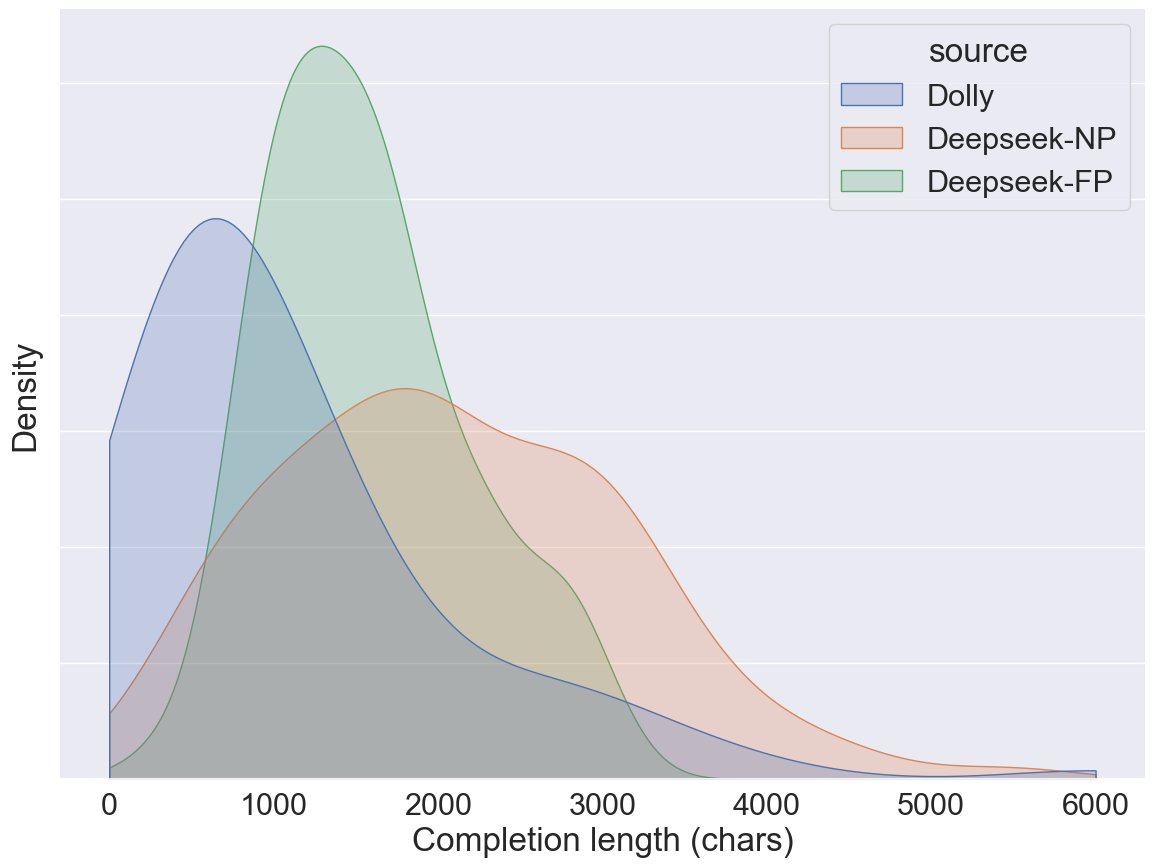

In [56]:
len_df = {'len': [], 'source':[]}

# Load all the human responses first.
len_df['len'] += sample['response'].apply(lambda x: len(x)).values.tolist()
len_df['source'] += ['Dolly' for _ in range(len(sample))]

for (df, source_name) in [(deep_npnc,'Deepseek-NP'), (deep_p, 'Deepseek-FP')]:
    if df.shape[0]>100:
        df['len'] = df.response.apply(lambda x: len(x))
        len_df['len'] += df.loc[:, ['prompt_id', 'len']].groupby('prompt_id').mean().len.values.tolist()
    else:
        len_df['len'] += df['response'].apply(lambda x: len(x)).values.tolist()
    len_df['source'] += [source_name for _ in range(100)]
    
len_df=pd.DataFrame(len_df)

g = sns.kdeplot(len_df, x='len', hue='source', common_norm=False, fill=True, clip=[0,6000])
g.set_xlabel('Completion length (chars)')
g.set_ylabel('Density')
g.spines["top"].set_visible(False)
g.spines["right"].set_visible(False)
g.spines["left"].set_visible(False)
g.set(yticklabels=[])
g.grid(axis='x')
# plt.legend([], [], frameon=False)
plt.show()

In [100]:
len_df = {'len': [], 'source':[]}

# Load all the human responses first.
len_df['len'] += sample['response'].apply(lambda x: len(x)).values.tolist()
len_df['source'] += ['Dolly' for _ in range(len(sample))]

for (df, source_name) in [(deep_npnc,'Deepseek-NP'), (deep_p, 'Deepseek-FP')]:
    len_df['len'] += df['response'].apply(lambda x: len(x)).values.tolist()
    len_df['source'] += [source_name for _ in range(len(df))]
    
len_df=pd.DataFrame(len_df)

g = sns.kdeplot(len_df, x='len', hue='source', common_norm=False, fill=True, clip=[0,8000])
g.set_xlabel('Completion length (chars)')
g.set_ylabel('Number of responses')
g.spines["top"].set_visible(False)
g.spines["right"].set_visible(False)
g.spines["left"].set_visible(False)
g.set(yticklabels=[])
g.grid(axis='x')
# plt.legend([], [], frameon=False)
# plt.show()
plt.savefig('length.png', bbox_inches='tight', transparent=True)